## Regression Problem

- Explore feature correlation
- Simple Linear Regression
- Evaluate Model with MSE, MAE, R-square


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
                 sep='\t',
                 usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [3]:
df.describe()

,Overall Qual,Overall Cond,Total Bsmt SF,Gr Liv Area,SalePrice
count,2930.000000,2930.000000,2929.000000,2930.000000,2930.000000
mean,6.094881,5.563140,1051.614544,1499.690444,180796.060068
std,1.411026,1.111537,440.615067,505.508887,79886.692357
min,1.000000,1.000000,0.000000,334.000000,12789.000000
25%,5.000000,5.000000,793.000000,1126.000000,129500.000000
50%,6.000000,5.000000,990.000000,1442.000000,160000.000000
75%,7.000000,6.000000,1302.000000,1742.750000,213500.000000
max,10.000000,9.000000,6110.000000,5642.000000,755000.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Overall Qual   2930 non-null   int64  
 1   Overall Cond   2930 non-null   int64  
 2   Total Bsmt SF  2929 non-null   float64
 3   Central Air    2930 non-null   object 
 4   Gr Liv Area    2930 non-null   int64  
 5   SalePrice      2930 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 137.5+ KB


In [5]:
# Encoding categorical feature
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [6]:
# Remove NaN
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

### Visualizing Feature Correlation

In [8]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

# Use pairplot as an alternative

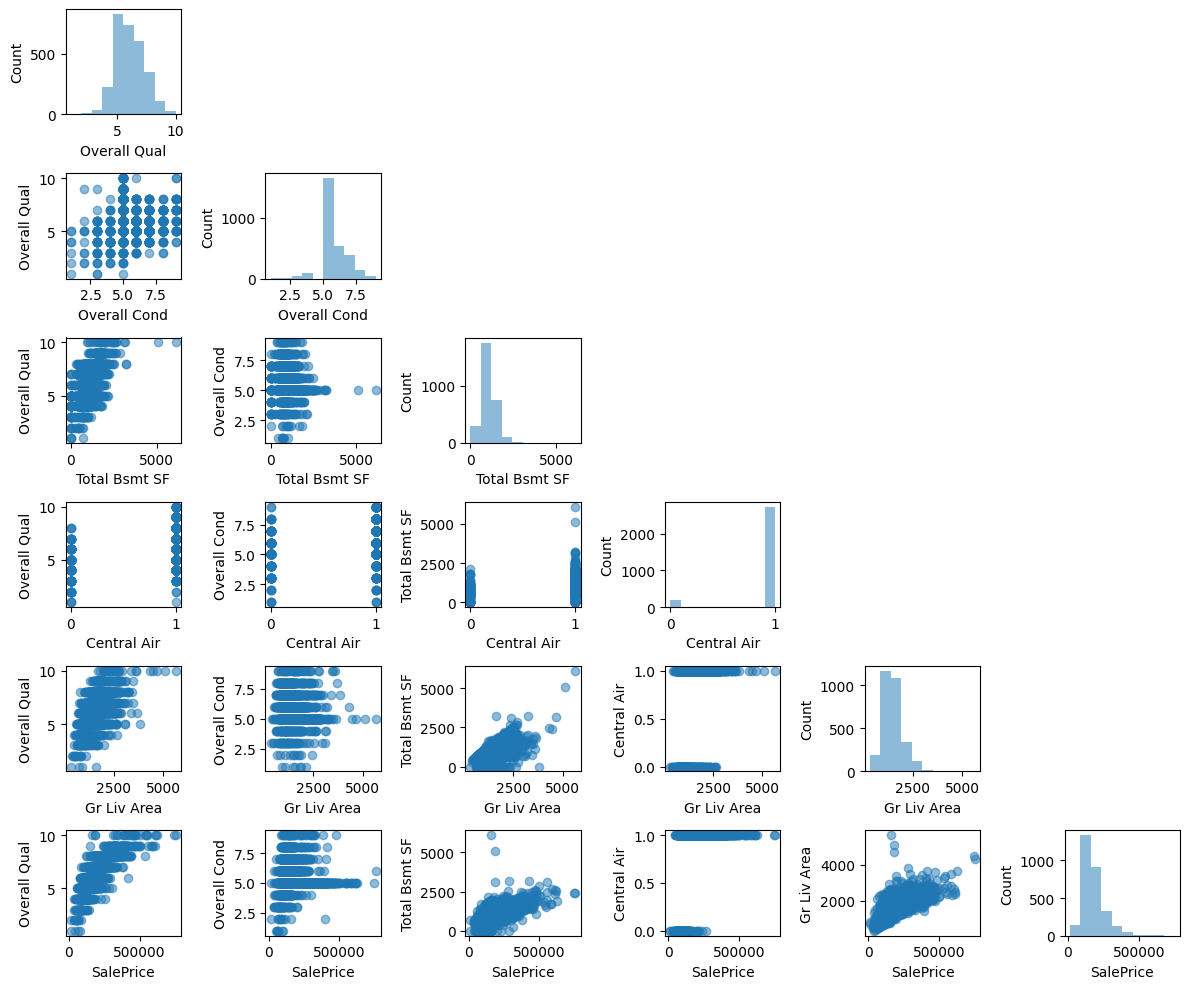

In [9]:
scatterplotmatrix(df.values, figsize=(12, 10),
                  names=df.columns, alpha=0.5)
plt.tight_layout()


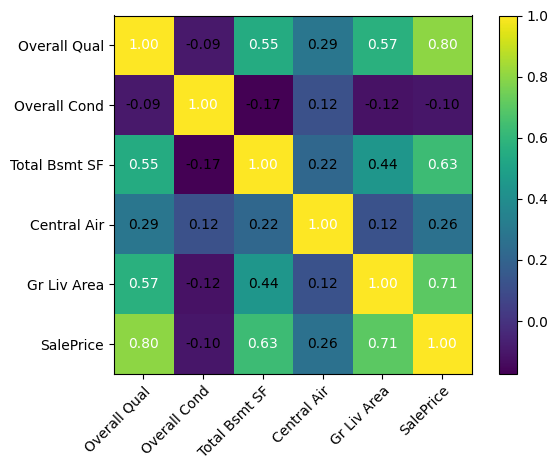

In [10]:
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)

plt.tight_layout()


### Estimating the coefficient of a regression model

In [11]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

In [12]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [13]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')


Slope: 111.666
Intercept: 13342.979


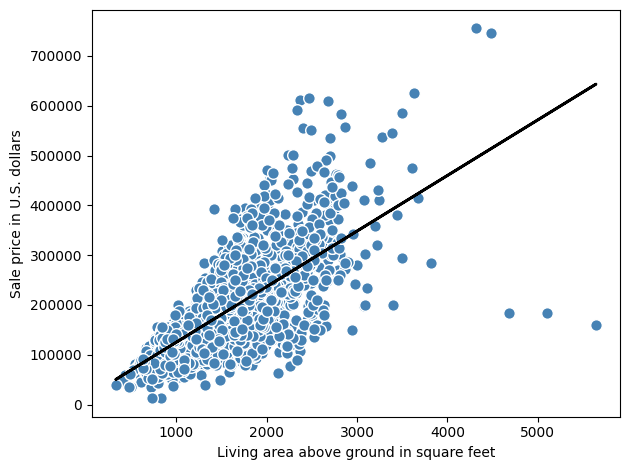

In [14]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return

lin_regplot(X, y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()


### Fitting a robust regression model using RANSAC

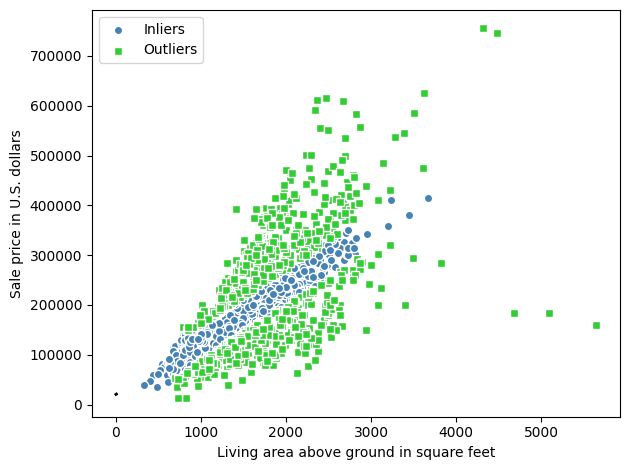

In [15]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100, # default
                         min_samples=0.95,
                         loss='absolute_error', # default
                         residual_threshold=None, # default
                         random_state=123)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()


In [16]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


### Evaluating the performance of linear regression models

In [17]:
from sklearn.model_selection import train_test_split


target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [18]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

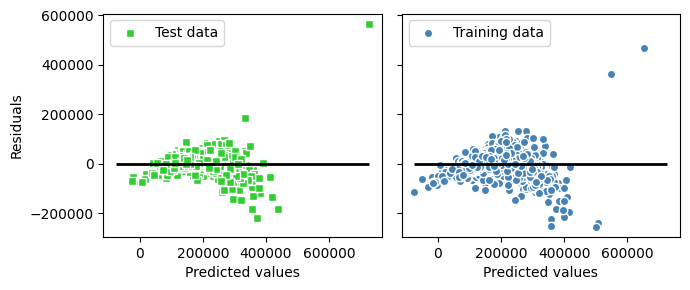

In [19]:
# Residual plot

x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()


In [20]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


In [21]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


In [22]:
from sklearn.metrics import r2_score

r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

R^2 train: 0.77
R^2 test: 0.75


### Apply regularization to regression

In [23]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[26251.38276394   804.70816337    41.94651964 11364.80761309
    55.67855548]


In [24]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {train_mse:.3f}, test: {test_mse:.3f}')

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

MSE train: 1497216262.014, test: 1516576825.348
R^2 train: 0.769, 0.752


In [25]:
from sklearn.linear_model import Lasso # L1

lasso = Lasso(alpha=1.0)

In [26]:
from sklearn.linear_model import Ridge # L2

ridge = Ridge(alpha=1.0)

In [27]:
from sklearn.linear_model import ElasticNet # L3

elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

### Dealing with nonlinear relationships using decision tree

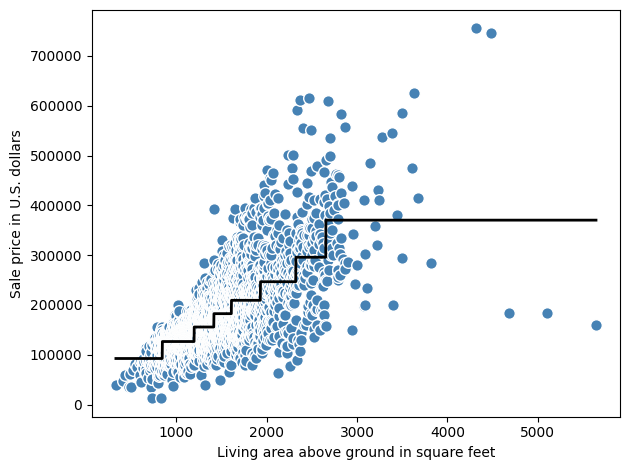

In [28]:
from sklearn.tree import DecisionTreeRegressor

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()


## Your work

Use your own dataset or the **Boston Housing Dataset** below.
- Preprocess the dataset, e.g. drop null
- Explore the correlation of features with scatterplotmatrix or pairplot. Find if there is any highly correlated feature.
- Select the independent (low correlated) features as the input of your multiple regression model.
- Split dataset, standardize features and run simple linear regression model.
- Evaluate model with MSE, MAE and R-square.

**Data Dictionary**.
http://lib.stat.cmu.edu/datasets/boston

**Submit your notebook in PDF to BrightSpace by 4/20 11:59 pm**.


In [69]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kabir\AppData\Local\Temp\ipykernel_29500\2958531800.py:5: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [70]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
5,392.83000,4.03,34.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.03237,0.00,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7
7,394.63000,2.94,33.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.06905,0.00,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7
9,396.90000,5.33,36.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
X.shape, y.shape

((506, 1), (506,))

In [72]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1012.000000,1012.000000,1012.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,180.143778,12.008350,16.834792,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534
std,188.132839,17.250728,9.912616,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000
25%,0.257830,0.000000,8.375000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000
50%,24.021000,7.240000,18.100000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000
75%,391.435000,16.780000,21.890000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000
max,396.900000,100.000000,50.000000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000


In [73]:
df.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

In [74]:
df = df.dropna(axis=0)
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

In [80]:
columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
    
] #adding back the columns to the dataframe
df.columns = columns[:len(df.columns)]

In [81]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO'],
      dtype='object')

In [77]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
2,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
4,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
6,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7
8,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7
...,...,...,...,...,...,...,...,...,...,...,...
1002,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0
1004,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0
1006,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0
1008,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0


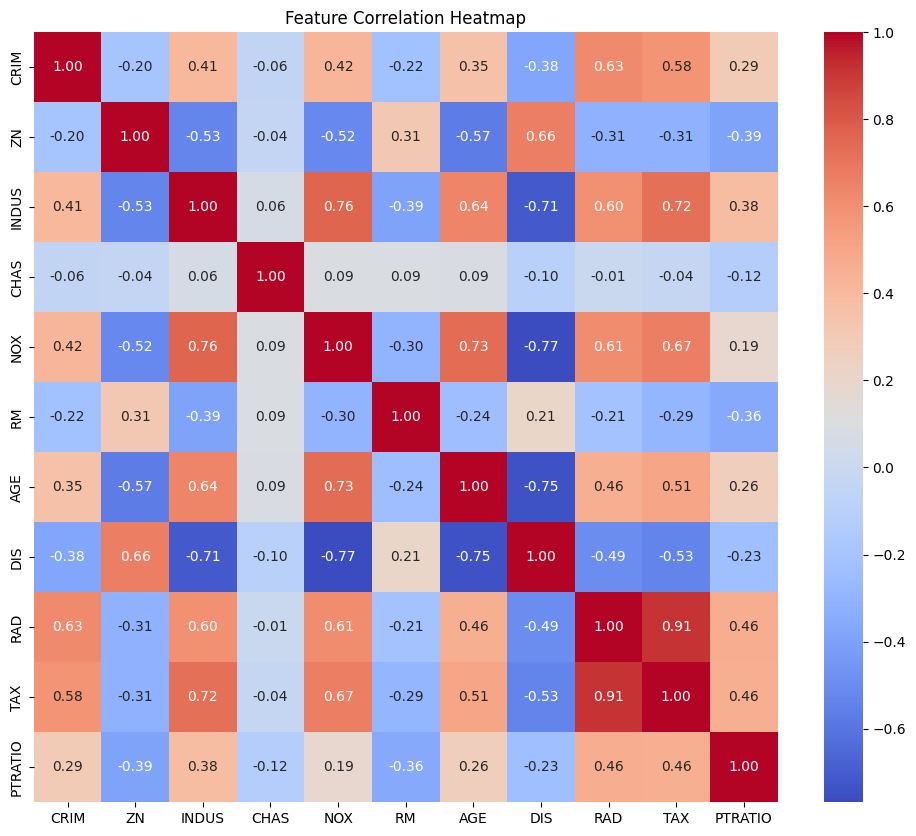

In [78]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [56]:
X = df.iloc[:, :10]
y = df.iloc[:, 10]


array([[<Axes: xlabel='CRIM', ylabel='CRIM'>,
        <Axes: xlabel='ZN', ylabel='CRIM'>,
        <Axes: xlabel='INDUS', ylabel='CRIM'>,
        <Axes: xlabel='CHAS', ylabel='CRIM'>,
        <Axes: xlabel='NOX', ylabel='CRIM'>,
        <Axes: xlabel='RM', ylabel='CRIM'>,
        <Axes: xlabel='AGE', ylabel='CRIM'>,
        <Axes: xlabel='DIS', ylabel='CRIM'>,
        <Axes: xlabel='RAD', ylabel='CRIM'>,
        <Axes: xlabel='TAX', ylabel='CRIM'>],
       [<Axes: xlabel='CRIM', ylabel='ZN'>,
        <Axes: xlabel='ZN', ylabel='ZN'>,
        <Axes: xlabel='INDUS', ylabel='ZN'>,
        <Axes: xlabel='CHAS', ylabel='ZN'>,
        <Axes: xlabel='NOX', ylabel='ZN'>,
        <Axes: xlabel='RM', ylabel='ZN'>,
        <Axes: xlabel='AGE', ylabel='ZN'>,
        <Axes: xlabel='DIS', ylabel='ZN'>,
        <Axes: xlabel='RAD', ylabel='ZN'>,
        <Axes: xlabel='TAX', ylabel='ZN'>],
       [<Axes: xlabel='CRIM', ylabel='INDUS'>,
        <Axes: xlabel='ZN', ylabel='INDUS'>,
        <Axes: xlabel=

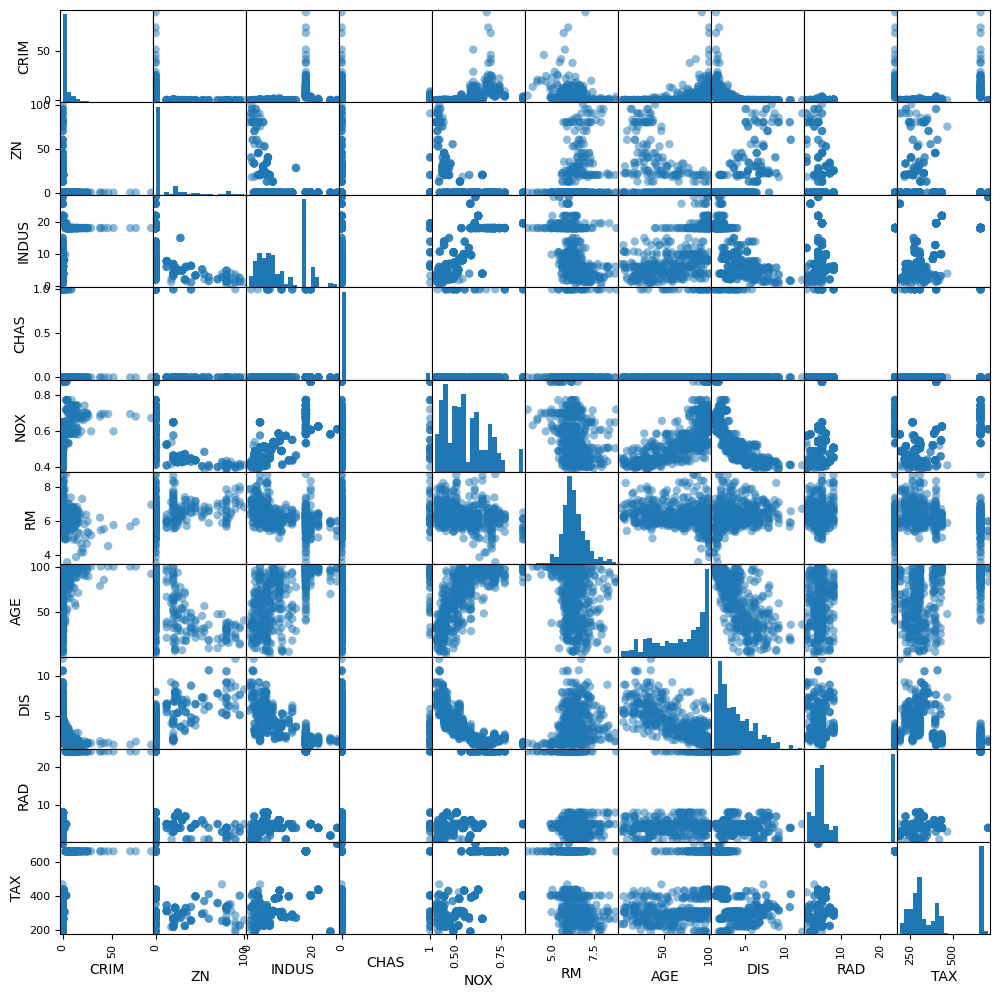

In [57]:
from pandas.plotting import scatter_matrix

scatter_matrix(
    X, 
    diagonal="hist", 
    figsize=(12,12), 
    marker="o",
    alpha=0.5,
    hist_kwds={'bins':20},
    grid=False
)

In [84]:
#using crim as the target
y = df['CRIM']  
X = df.drop(columns=['CRIM'])

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [87]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [88]:
y_pred = model.predict(X_test)


In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 28.54
Mean Absolute Error: 2.96
R^2 Score: 0.48


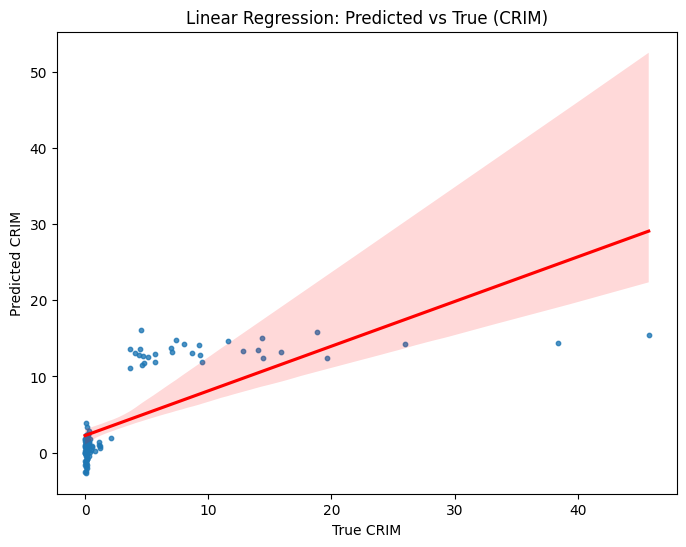

In [91]:
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Linear Regression: Predicted vs True (CRIM)')
plt.xlabel('True CRIM')
plt.ylabel('Predicted CRIM')
plt.show()

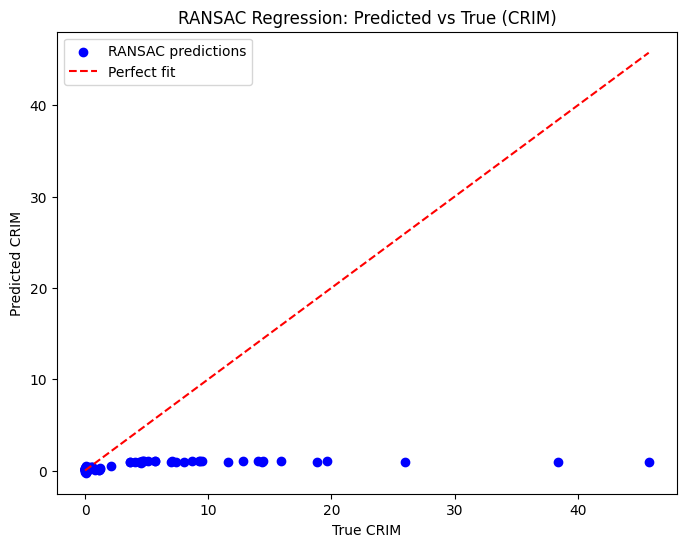

In [93]:
ransac = RANSACRegressor()
ransac.fit(X_train, y_train)
y_ransac = ransac.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_ransac, color='blue', label='RANSAC predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.title('RANSAC Regression: Predicted vs True (CRIM)')
plt.xlabel('True CRIM')
plt.ylabel('Predicted CRIM')
plt.legend()
plt.show()

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

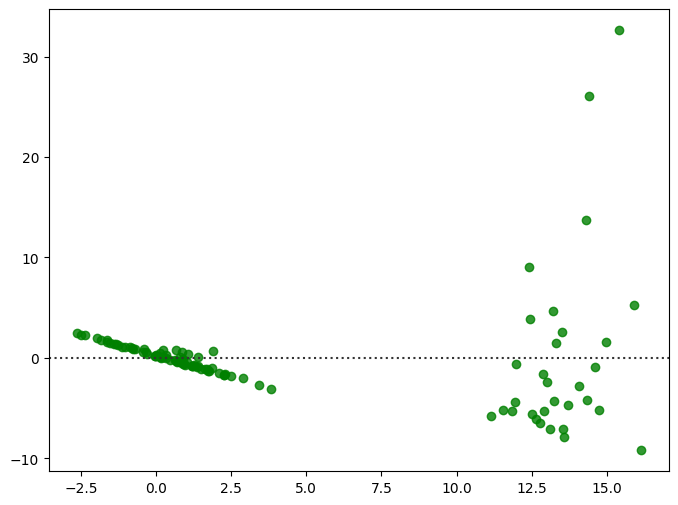

In [96]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g", line_kws={'color': 'red'})
plt.title('Residual Plot for Linear Regression (CRIM)')
plt.xlabel('Predicted CRIM')
plt.ylabel('Residuals')
plt.show()

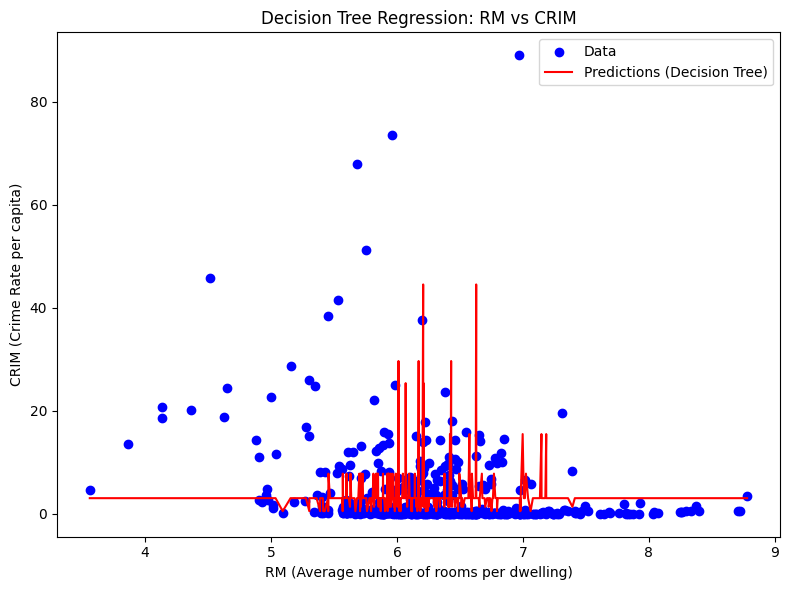

In [100]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
# Select the feature and target
X = df[['RM']].values  # using RM (average number of rooms per dwelling) as the feature
y = df['CRIM'].values  # Target variable (CRIM)

# Fit the DecisionTreeRegressor model
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

# Sort the values of X for plotting
sort_idx = X.flatten().argsort()

# Plotting the regression tree predictions
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X[sort_idx], tree.predict(X[sort_idx].reshape(-1, 1))[sort_idx], color='red', label='Predictions (Decision Tree)')
plt.xlabel('RM (Average number of rooms per dwelling)')
plt.ylabel('CRIM (Crime Rate per capita)')
plt.title('Decision Tree Regression: RM vs CRIM')
plt.legend()
plt.tight_layout()
plt.show()


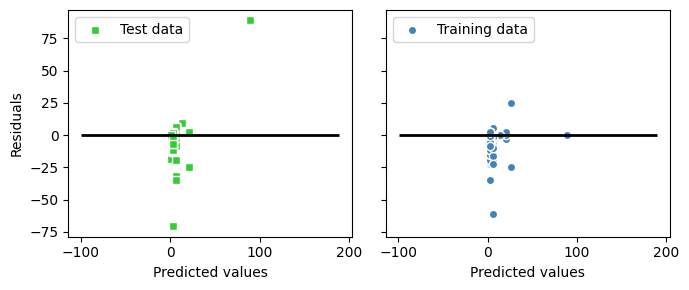

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the DecisionTreeRegressor model
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

# Create the residual plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# Plot residuals for test data
ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
# Plot residuals for training data
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')

# Set labels
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

# Tight layout for better spacing
plt.tight_layout()
plt.show()